In [2]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt

# tf.enable_eager_execution()

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# I make a link to the folder without the stupid space in it. 
!ln -s "/content/gdrive/My Drive" "/content/mydrive"

In [6]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test

# If there are errors with SSL downloading involving self-signed certificates,
# it may be that your Python version was recently installed on the current machine.
# See: https://github.com/tensorflow/tensorflow/issues/10779
# To fix, run the command: /Applications/Python\ 3.7/Install\ Certificates.command
#   ...replacing paths as necessary.

# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

170500096/170498071 [==============================] - 11s 0us/step
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [8]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


Nbatch=128
train_dset = Dataset(X_train, y_train, batch_size=Nbatch, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=Nbatch, shuffle=False)
test_dset = Dataset(X_test, y_test, batch_size=Nbatch)

In [9]:
### I modified my own train function to print results to a file, and my own eval function.
def train(model_init_fn, optimizer_init_fn, num_epochs=1,reg=0, model_name='',is_training=False):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during trainingn
    """    
    with tf.device(device):

        # checkpoint_path = "training_1/cp.ckpt"
        checkpoint_path='/content/mydrive/'+model_name+'/'
        checkpoint_name=checkpoint_path+'cp-{epoch:03d}.ckpt'
        
        results_path='/content/mydrive/'+model_name+'/'
        if not os.path.exists(results_path):
          os.makedirs(results_path)
        # results_file=open(results_path+'results.txt','a+')
        print(checkpoint_name)
        # print(results_file)
        # try:
        #   results_file.write('The file has a string!')
        #   print('just wrote to results.txt')
        # except:
        #   print('coudnt write to file')
        checkpoint_dir = os.path.dirname(checkpoint_path)
        latest = tf.train.latest_checkpoint(checkpoint_path)
        print(latest)
        # Create a callback that saves the model's weights
        # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
        #                                          save_weights_only=True,
        #                                          verbose=1)
        # Compute the loss
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        reg_fn = tf.keras.regularizers.l2(l=reg)
        
        model = model_init_fn()
        optimizer = optimizer_init_fn()
        if latest != None:
          model.load_weights(latest)
          print(latest[len(checkpoint_path)+3:34])
          start_epoch=int(latest[len(checkpoint_path)+3:34])
        else:
          start_epoch=0
        print('start epoch: '+str(start_epoch))

        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    
        val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

#         test_loss = tf.keras.metrics.Mean(name='test_loss')
#         test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

        results = []
        t = 0
        for epoch in range(start_epoch+1,num_epochs):
            count=0      
            # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
            train_loss.reset_states()
            train_accuracy.reset_states()
      
            for x_tr, y_tr in train_dset:
                with tf.GradientTape() as tape:                    
                    # Use the model function to build the forward pass.
                    scores = model(x_tr, training=is_training)
                    loss = loss_fn(y_tr, scores)
                    loss += reg*sum(model.losses)
                    
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    # Update the metrics
                    train_loss.update_state(loss)
                    train_accuracy.update_state(y_tr, scores)
                    
                    if t % print_every == 0:
                        val_loss.reset_states()
                        val_accuracy.reset_states()
                        for val_x, val_y in val_dset:
                            # During validation at end of epoch, training set to False
                            prediction = model(val_x, training=False)
                            t_loss = loss_fn(val_y, prediction)

                            val_loss.update_state(t_loss)
                            val_accuracy.update_state(val_y, prediction)
                        
                        template = 'Iteration {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss: {:.2f}, Val Accuracy: {:.2f}'
                        templateN = 'Iteration {}, Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss: {:.2f}, Val Accuracy: {:.2f}\n'
                        # print (template.format(t, epoch,
                        #                      train_loss.result(), train_accuracy.result()*100,
                        #                      val_loss.result(), val_accuracy.result()*100))
                        results_str0 = template.format(t, epoch,
                                             train_loss.result(), train_accuracy.result()*100,
                                             val_loss.result(), val_accuracy.result()*100)
                        results_str = templateN.format(t, epoch,
                                             train_loss.result(), train_accuracy.result()*100,
                                             val_loss.result(), val_accuracy.result()*100)
                        print(results_str0)
                        with open(results_path+'results.txt','a+') as f:
                          f.write(results_str)
                          f.close()
                        res = {
                            'iteration':t, 'epoch': epoch,
                            'train loss':train_loss.result(), 'train acc':train_accuracy.result()*100,
                            'val loss':val_loss.result(), 'val acc':val_accuracy.result()*100,
                                }
                        results.append(res)
                    t += 1
                    count+=1
            # print(count)
            max_iter = count
            model.save_weights(checkpoint_name.format(epoch=epoch))
        print('training done')
    return model, results, max_iter

def eval(model):
    with tf.device(device):
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        test_loss = tf.keras.metrics.Mean(name='test_loss')
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

        test_results=[]
        for x_t, y_t in test_dset:

            t_pred = model(x_t, training=False)
            t_loss = loss_fn(y_t, t_pred)
            test_loss.update_state(t_loss)
            test_accuracy.update_state(y_t, t_pred)
        test_template = 'Test Loss: {:.2f}, Test Accuracy: {:.2f}'
        print (test_template.format(
                        test_loss.result(),
                        test_accuracy.result()*100))
        test_results = {'test loss':test_loss.result(),'test acc':test_accuracy.result()*100}
    return test_results

In [10]:
### Here I define a bunch of custom ConvNets with different combinations of conv and dense layer stacks, similar to VGG in style
### 2C1D, 2C2D, 3C1D, 3C2D, 4C1D, 4C2D, 4C3D, with BatchNorm and DropOut
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Activation
class CustomConvNet_2C2DwBNDO(tf.keras.Model):
    def __init__(self, num_classes,reg):
        super(CustomConvNet_2C2DwBNDO, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)
        self.bn1_1   = BatchNormalization()
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn1_2   = BatchNormalization()
        self.mp1     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_1   = BatchNormalization()
        self.conv3_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_2   = BatchNormalization()
        self.conv3_3 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_3   = BatchNormalization()
        self.mp3     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        self.drop1   = Dropout(0.3)        
        self.drop3_1 = Dropout(0.4)        
        self.drop3_2 = Dropout(0.4)        
        self.drop3_3 = Dropout(0.5)        
        self.dropFC  = Dropout(0.5)        

        ### LayerFC ###
        self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc2 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):

        x = input_tensor    #HWC=32x32x3
        x = self.conv1_1(x) #32        
        x = self.bn1_1(x)
        x = self.drop1(x)
        x = self.conv1_2(x) #32
        x = self.bn1_2(x)
        x = self.mp1(x)     #->16x16x32 = 8192
        
        x = self.conv3_1(x) #64        
        x = self.bn3_1(x)
        x = self.drop3_1(x)
        x = self.conv3_2(x) #64
        x = self.bn3_2(x)
        x = self.drop3_2(x)
        x = self.conv3_3(x) #64
        x = self.bn3_3(x)
        x = self.mp3(x)     #->8x8x64 = 4096
        x = self.drop3_3(x)

        x      = self.flatten(x) #->4096x1
        x      = self.fc1(x)
        x      = self.dropFC(x)
        scores = self.fc2(x)

        return scores


class CustomConvNet_2C1DwBNDO(tf.keras.Model):
    def __init__(self, num_classes,reg):
        super(CustomConvNet_2C1DwBNDO, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)
        self.bn1_1   = BatchNormalization()
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn1_2   = BatchNormalization()
        self.mp1     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_1   = BatchNormalization()
        self.conv3_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_2   = BatchNormalization()
        self.conv3_3 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_3   = BatchNormalization()
        self.mp3     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        self.drop1   = Dropout(0.3)        
        self.drop3_1 = Dropout(0.4)        
        self.drop3_2 = Dropout(0.4)        
        self.drop3_3 = Dropout(0.5)        
        self.dropFC  = Dropout(0.5)        

        ### LayerFC ###
        # self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc2 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):

        x = input_tensor    #HWC=32x32x3
        x = self.conv1_1(x) #32        
        x = self.bn1_1(x)
        x = self.drop1(x)
        x = self.conv1_2(x) #32
        x = self.bn1_2(x)
        x = self.mp1(x)     #->16x16x32 = 8192
        
        x = self.conv3_1(x) #64        
        x = self.bn3_1(x)
        x = self.drop3_1(x)
        x = self.conv3_2(x) #64
        x = self.bn3_2(x)
        x = self.drop3_2(x)
        x = self.conv3_3(x) #64
        x = self.bn3_3(x)
        x = self.mp3(x)     #->8x8x64 = 4096
        # x = self.drop3_3(x)

        x      = self.flatten(x) #->4096x1
        # x      = self.fc1(x)
        x      = self.dropFC(x)
        scores = self.fc2(x)

        return scores


class CustomConvNet_3C2DwBNDO(tf.keras.Model):
    def __init__(self, num_classes,reg):
        super(CustomConvNet_3C2DwBNDO, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)
        self.bn1_1   = BatchNormalization()
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn1_2   = BatchNormalization()
        self.mp1     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer2 ###
        self.conv2_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_1   = BatchNormalization()
        self.conv2_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_2   = BatchNormalization()
        self.mp2     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_1   = BatchNormalization()
        self.conv3_2 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_2   = BatchNormalization()
        self.conv3_3 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_3   = BatchNormalization()
        self.mp3     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        self.drop1   = Dropout(0.3)        
        self.drop2   = Dropout(0.4)        
        self.drop3_1 = Dropout(0.4)        
        self.drop3_2 = Dropout(0.4)        
        self.drop3_3 = Dropout(0.5)        
        self.dropFC  = Dropout(0.5)        

        ### LayerFC ###
        self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc2 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):

        x = input_tensor    #HWC=32x32x3
        x = self.conv1_1(x) #32        
        x = self.bn1_1(x)
        x = self.drop1(x)
        x = self.conv1_2(x) #32
        x = self.bn1_2(x)
        x = self.mp1(x)     #->16x16x32 = 8192

        x = self.conv2_1(x) #64        
        x = self.bn2_1(x)
        x = self.drop2(x)
        x = self.conv2_2(x) #64
        x = self.bn2_2(x)
        x = self.mp2(x)     #->8x8x64 = 4096
        
        x = self.conv3_1(x) #128        
        x = self.bn3_1(x)
        x = self.drop3_1(x)
        x = self.conv3_2(x) #128
        x = self.bn3_2(x)
        x = self.drop3_2(x)
        x = self.conv3_3(x) #128
        x = self.bn3_3(x)
        x = self.mp3(x)     #->4x4x128 = 2048
        x = self.drop3_3(x)

        x      = self.flatten(x) #->1024x1
        x      = self.fc1(x)
        x      = self.dropFC(x)
        scores = self.fc2(x)

        return scores

class CustomConvNet_3C1DwBNDO(tf.keras.Model):
    def __init__(self, num_classes,reg):
        super(CustomConvNet_3C1DwBNDO, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)
        self.bn1_1   = BatchNormalization()
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn1_2   = BatchNormalization()
        self.mp1     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer2 ###
        self.conv2_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_1   = BatchNormalization()
        self.conv2_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_2   = BatchNormalization()
        self.mp2     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_1   = BatchNormalization()
        self.conv3_2 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_2   = BatchNormalization()
        self.conv3_3 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_3   = BatchNormalization()
        self.mp3     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        self.drop1   = Dropout(0.3)        
        self.drop2   = Dropout(0.4)        
        self.drop3_1 = Dropout(0.4)        
        self.drop3_2 = Dropout(0.4)        
        self.dropFC  = Dropout(0.5)        

        ### LayerFC ###
        self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc2 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):

        x = input_tensor    #HWC=32x32x3
        x = self.conv1_1(x) #32        
        x = self.bn1_1(x)
        x = self.drop1(x)
        x = self.conv1_2(x) #32
        x = self.bn1_2(x)
        x = self.mp1(x)     #->16x16x32 = 8192

        x = self.conv2_1(x) #64        
        x = self.bn2_1(x)
        x = self.drop2(x)
        x = self.conv2_2(x) #64
        x = self.bn2_2(x)
        x = self.mp2(x)     #->8x8x64 = 4096
        
        x = self.conv3_1(x) #128        
        x = self.bn3_1(x)
        x = self.drop3_1(x)
        x = self.conv3_2(x) #128
        x = self.bn3_2(x)
        x = self.drop3_2(x)
        x = self.conv3_3(x) #128
        x = self.bn3_3(x)
        x = self.mp3(x)     #->4x4x128 = 2048
 
        x      = self.flatten(x) #->1024x1
        x      = self.dropFC(x)
        scores = self.fc2(x)

        return scores


class CustomConvNet_4C2DwBNDO(tf.keras.Model):
    def __init__(self, num_classes,reg):
        super(CustomConvNet_4C2DwBNDO, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)
        self.bn1_1   = BatchNormalization()
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn1_2   = BatchNormalization()
        self.mp1     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer2 ###
        self.conv2_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_1   = BatchNormalization()
        self.conv2_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_2   = BatchNormalization()
        self.mp2     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_1   = BatchNormalization()
        self.conv3_2 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_2   = BatchNormalization()
        self.conv3_3 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_3   = BatchNormalization()
        self.mp3     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer4 ###
        self.conv4_1 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_1   = BatchNormalization()
        self.conv4_2 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_2   = BatchNormalization()
        self.conv4_3 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_3   = BatchNormalization()
        self.mp4     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        self.drop1   = Dropout(0.3)        
        self.drop2   = Dropout(0.4)        
        self.drop3_1 = Dropout(0.4)        
        self.drop3_2 = Dropout(0.4)        
        self.drop4_1 = Dropout(0.4)        
        self.drop4_2 = Dropout(0.4)        
        self.drop4_3 = Dropout(0.5)        
        self.dropFC  = Dropout(0.5)        

        ### LayerFC ###
        self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc2 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):

        x = input_tensor    #HWC=32x32x3
        x = self.conv1_1(x) #32        
        x = self.bn1_1(x)
        x = self.drop1(x)
        x = self.conv1_2(x) #32
        x = self.bn1_2(x)
        x = self.mp1(x)     #->16x16x32 = 8192

        x = self.conv2_1(x) #64        
        x = self.bn2_1(x)
        x = self.drop2(x)
        x = self.conv2_2(x) #64
        x = self.bn2_2(x)
        x = self.mp2(x)     #->8x8x64 = 4096
        
        x = self.conv3_1(x) #128        
        x = self.bn3_1(x)
        x = self.drop3_1(x)
        x = self.conv3_2(x) #128
        x = self.bn3_2(x)
        x = self.drop3_2(x)
        x = self.conv3_3(x) #128
        x = self.bn3_3(x)
        x = self.mp3(x)     #->4x4x128 = 2048

        # x = self.dropout1(x)
        # x = self.dropout2(x)
        x = self.conv4_1(x) #256        
        x = self.bn4_1(x)
        x = self.drop4_1(x)
        x = self.conv4_2(x) #256
        x = self.bn4_2(x)
        x = self.drop4_2(x)
        x = self.conv4_3(x) #256
        x = self.bn4_3(x)
        x = self.mp4(x)     #->2x2x256 = 1024
        x = self.drop4_3(x)
        # x = squeeze_excite_block(x, ratio=16)

        x      = self.flatten(x) #->1024x1
        x      = self.fc1(x)
        x      = self.dropFC(x)
        scores = self.fc2(x)

        return scores

class CustomConvNet_4C2DwDO(tf.keras.Model):
    def __init__(self, num_classes,reg):
        super(CustomConvNet_4C2DwDO, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)
        # self.bn1_1   = BatchNormalization()
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn1_2   = BatchNormalization()
        self.mp1     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer2 ###
        self.conv2_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn2_1   = BatchNormalization()
        self.conv2_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn2_2   = BatchNormalization()
        self.mp2     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn3_1   = BatchNormalization()
        self.conv3_2 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn3_2   = BatchNormalization()
        self.conv3_3 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn3_3   = BatchNormalization()
        self.mp3     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer4 ###
        self.conv4_1 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn4_1   = BatchNormalization()
        self.conv4_2 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn4_2   = BatchNormalization()
        self.conv4_3 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn4_3   = BatchNormalization()
        self.mp4     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        self.drop1   = Dropout(0.3)        
        self.drop2   = Dropout(0.4)        
        self.drop3_1 = Dropout(0.4)        
        self.drop3_2 = Dropout(0.4)        
        self.drop4_1 = Dropout(0.4)        
        self.drop4_2 = Dropout(0.4)        
        self.drop4_3 = Dropout(0.5)        
        self.dropFC  = Dropout(0.5)        

        ### LayerFC ###
        self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc2 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):
        x = input_tensor    #HWC=32x32x3
        x = self.conv1_1(x) #32        
        # x = self.bn1_1(x)
        x = self.drop1(x)
        x = self.conv1_2(x) #32
        # x = self.bn1_2(x)
        x = self.mp1(x)     #->16x16x32 = 8192

        x = self.conv2_1(x) #64        
        # x = self.bn2_1(x)
        x = self.drop2(x)
        x = self.conv2_2(x) #64
        # x = self.bn2_2(x)
        x = self.mp2(x)     #->8x8x64 = 4096
        
        x = self.conv3_1(x) #128        
        # x = self.bn3_1(x)
        x = self.drop3_1(x)
        x = self.conv3_2(x) #128
        # x = self.bn3_2(x)
        x = self.drop3_2(x)
        x = self.conv3_3(x) #128
        # x = self.bn3_3(x)
        x = self.mp3(x)     #->4x4x128 = 2048

        # x = self.dropout1(x)
        # x = self.dropout2(x)
        x = self.conv4_1(x) #256        
        # x = self.bn4_1(x)
        x = self.drop4_1(x)
        x = self.conv4_2(x) #256
        # x = self.bn4_2(x)
        x = self.drop4_2(x)
        x = self.conv4_3(x) #256
        # x = self.bn4_3(x)
        x = self.mp4(x)     #->2x2x256 = 1024
        x = self.drop4_3(x)
        # x = squeeze_excite_block(x, ratio=16)

        x      = self.flatten(x) #->1024x1
        x      = self.fc1(x)
        x      = self.dropFC(x)
        scores = self.fc2(x)
        return scores

class CustomConvNet_4C2DwBN(tf.keras.Model):
    def __init__(self, num_classes,reg):
        super(CustomConvNet_4C2DwBN, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)
        self.bn1_1   = BatchNormalization()
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn1_2   = BatchNormalization()
        self.mp1     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer2 ###
        self.conv2_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_1   = BatchNormalization()
        self.conv2_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_2   = BatchNormalization()
        self.mp2     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_1   = BatchNormalization()
        self.conv3_2 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_2   = BatchNormalization()
        self.conv3_3 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_3   = BatchNormalization()
        self.mp3     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer4 ###
        self.conv4_1 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_1   = BatchNormalization()
        self.conv4_2 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_2   = BatchNormalization()
        self.conv4_3 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_3   = BatchNormalization()
        self.mp4     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        # self.drop1   = Dropout(0.3)        
        # self.drop2   = Dropout(0.4)        
        # self.drop3_1 = Dropout(0.4)        
        # self.drop3_2 = Dropout(0.4)        
        # self.drop4_1 = Dropout(0.4)        
        # self.drop4_2 = Dropout(0.4)        
        # self.drop4_3 = Dropout(0.5)        
        # self.dropFC  = Dropout(0.5)        

        ### LayerFC ###
        self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc2 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):
        x = input_tensor    #HWC=32x32x3
        x = self.conv1_1(x) #32        
        x = self.bn1_1(x)
        # x = self.drop1(x)
        x = self.conv1_2(x) #32
        x = self.bn1_2(x)
        x = self.mp1(x)     #->16x16x32 = 8192

        x = self.conv2_1(x) #64        
        x = self.bn2_1(x)
        # x = self.drop2(x)
        x = self.conv2_2(x) #64
        x = self.bn2_2(x)
        x = self.mp2(x)     #->8x8x64 = 4096
        
        x = self.conv3_1(x) #128        
        x = self.bn3_1(x)
        # x = self.drop3_1(x)
        x = self.conv3_2(x) #128
        x = self.bn3_2(x)
        # x = self.drop3_2(x)
        x = self.conv3_3(x) #128
        x = self.bn3_3(x)
        x = self.mp3(x)     #->4x4x128 = 2048

        # x = self.dropout1(x)
        # x = self.dropout2(x)
        x = self.conv4_1(x) #256        
        x = self.bn4_1(x)
        # x = self.drop4_1(x)
        x = self.conv4_2(x) #256
        x = self.bn4_2(x)
        # x = self.drop4_2(x)
        x = self.conv4_3(x) #256
        x = self.bn4_3(x)
        x = self.mp4(x)     #->2x2x256 = 1024
        # x = self.drop4_3(x)

        x      = self.flatten(x) #->1024x1
        x      = self.fc1(x)
        # x      = self.dropFC(x)
        scores = self.fc2(x)
        return scores


class CustomConvNet_4C2D(tf.keras.Model):
    def __init__(self, num_classes,reg):
        super(CustomConvNet_4C2D, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)
        # self.bn1_1   = BatchNormalization()
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn1_2   = BatchNormalization()
        self.mp1     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer2 ###
        self.conv2_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn2_1   = BatchNormalization()
        self.conv2_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn2_2   = BatchNormalization()
        self.mp2     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn3_1   = BatchNormalization()
        self.conv3_2 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn3_2   = BatchNormalization()
        self.conv3_3 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn3_3   = BatchNormalization()
        self.mp3     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer4 ###
        self.conv4_1 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn4_1   = BatchNormalization()
        self.conv4_2 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn4_2   = BatchNormalization()
        self.conv4_3 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        # self.bn4_3   = BatchNormalization()
        self.mp4     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        # self.drop1   = Dropout(0.3)        
        # self.drop2   = Dropout(0.4)        
        # self.drop3_1 = Dropout(0.4)        
        # self.drop3_2 = Dropout(0.4)        
        # self.drop4_1 = Dropout(0.4)        
        # self.drop4_2 = Dropout(0.4)        
        # self.drop4_3 = Dropout(0.5)        
        # self.dropFC  = Dropout(0.5)        

        ### LayerFC ###
        self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc2 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):
        x = input_tensor    #HWC=32x32x3
        x = self.conv1_1(x) #32        
        # x = self.bn1_1(x)
        # x = self.drop1(x)
        x = self.conv1_2(x) #32
        # x = self.bn1_2(x)
        x = self.mp1(x)     #->16x16x32 = 8192

        x = self.conv2_1(x) #64        
        # x = self.bn2_1(x)
        # x = self.drop2(x)
        x = self.conv2_2(x) #64
        # x = self.bn2_2(x)
        x = self.mp2(x)     #->8x8x64 = 4096
        
        x = self.conv3_1(x) #128        
        # x = self.bn3_1(x)
        # x = self.drop3_1(x)
        x = self.conv3_2(x) #128
        # x = self.bn3_2(x)
        # x = self.drop3_2(x)
        x = self.conv3_3(x) #128
        # x = self.bn3_3(x)
        x = self.mp3(x)     #->4x4x128 = 2048

        # x = self.dropout1(x)
        # x = self.dropout2(x)
        x = self.conv4_1(x) #256        
        # x = self.bn4_1(x)
        # x = self.drop4_1(x)
        x = self.conv4_2(x) #256
        # x = self.bn4_2(x)
        # x = self.drop4_2(x)
        x = self.conv4_3(x) #256
        # x = self.bn4_3(x)
        x = self.mp4(x)     #->2x2x256 = 1024
        # x = self.drop4_3(x)
        # x = squeeze_excite_block(x, ratio=16)

        x      = self.flatten(x) #->1024x1
        x      = self.fc1(x)
        # x      = self.dropFC(x)
        scores = self.fc2(x)
        return scores

class CustomConvNet_4C1DwBNDO(tf.keras.Model):
    def __init__(self, num_classes,reg):
        super(CustomConvNet_4C1DwBNDO, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)
        self.bn1_1   = BatchNormalization()
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn1_2   = BatchNormalization()
        self.mp1     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer2 ###
        self.conv2_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_1   = BatchNormalization()
        self.conv2_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_2   = BatchNormalization()
        self.mp2     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_1   = BatchNormalization()
        self.conv3_2 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_2   = BatchNormalization()
        self.conv3_3 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_3   = BatchNormalization()
        self.mp3     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer4 ###
        self.conv4_1 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_1   = BatchNormalization()
        self.conv4_2 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_2   = BatchNormalization()
        self.conv4_3 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_3   = BatchNormalization()
        self.mp4     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        self.drop1   = Dropout(0.3)        
        self.drop2   = Dropout(0.4)        
        self.drop3_1 = Dropout(0.4)        
        self.drop3_2 = Dropout(0.4)        
        self.drop4_1 = Dropout(0.4)        
        self.drop4_2 = Dropout(0.4)        
        self.drop4_3 = Dropout(0.5)        
        self.dropFC  = Dropout(0.5)        

        ### LayerFC ###
        # self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc2 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):

        x = input_tensor    #HWC=32x32x3
        x = self.conv1_1(x) #32        
        x = self.bn1_1(x)
        x = self.drop1(x)
        x = self.conv1_2(x) #32
        x = self.bn1_2(x)
        x = self.mp1(x)     #->16x16x32 = 8192

        x = self.conv2_1(x) #64        
        x = self.bn2_1(x)
        x = self.drop2(x)
        x = self.conv2_2(x) #64
        x = self.bn2_2(x)
        x = self.mp2(x)     #->8x8x64 = 4096
        
        x = self.conv3_1(x) #128        
        x = self.bn3_1(x)
        x = self.drop3_1(x)
        x = self.conv3_2(x) #128
        x = self.bn3_2(x)
        x = self.drop3_2(x)
        x = self.conv3_3(x) #128
        x = self.bn3_3(x)
        x = self.mp3(x)     #->4x4x128 = 2048

        # x = self.dropout1(x)
        # x = self.dropout2(x)
        x = self.conv4_1(x) #256        
        x = self.bn4_1(x)
        x = self.drop4_1(x)
        x = self.conv4_2(x) #256
        x = self.bn4_2(x)
        x = self.drop4_2(x)
        x = self.conv4_3(x) #256
        x = self.bn4_3(x)
        x = self.mp4(x)     #->2x2x256 = 1024
        x = self.drop4_3(x)
        # x = squeeze_excite_block(x, ratio=16)

        x      = self.flatten(x) #->1024x1
        # x      = self.fc1(x)
        x      = self.dropFC(x)
        scores = self.fc2(x)

        return scores

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Activation
class CustomConvNet_4C1D(tf.keras.Model):
    def __init__(self, num_classes, reg, drop):
        super(CustomConvNet_4C1D, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)        
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
            kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer, bias_regularizer=regularizer)
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
            kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer, bias_regularizer=regularizer)
        self.mp1 = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer2 ###
        self.conv2_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
            kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer, bias_regularizer=regularizer)
        self.conv2_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
            kernel_initializer=initializer, bias_initializer='zeros',kernel_regularizer=regularizer, bias_regularizer=regularizer)
        self.mp2 = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
            kernel_initializer=initializer, bias_initializer='zeros',kernel_regularizer=regularizer, bias_regularizer=regularizer)
        self.conv3_2 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
            kernel_initializer=initializer, bias_initializer='zeros',kernel_regularizer=regularizer, bias_regularizer=regularizer)
        self.conv3_3 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
            kernel_initializer=initializer, bias_initializer='zeros',kernel_regularizer=regularizer, bias_regularizer=regularizer)
        self.mp3 = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer4 ###
        self.conv4_1 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
            kernel_initializer=initializer, bias_initializer='zeros',kernel_regularizer=regularizer, bias_regularizer=regularizer)
        self.conv4_2 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
            kernel_initializer=initializer, bias_initializer='zeros',kernel_regularizer=regularizer, bias_regularizer=regularizer)
        self.conv4_3 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
            kernel_initializer=initializer, bias_initializer='zeros',kernel_regularizer=regularizer, bias_regularizer=regularizer)
        self.mp4 = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')

        self.dropout1 = Dropout(drop)        
        self.dropout2 = Dropout(drop)        

        ### LayerFC ###
        self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer)
        self.fc2 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):

        x = input_tensor    #HWC=32x32x3
        x = self.conv1_1(x) #32        
        x = self.conv1_2(x) #32
        x = self.mp1(x)     #->16x16x32 = 8192
        # x = self.dropout1(x)

        x = self.conv2_1(x) #64        
        x = self.conv2_2(x) #64
        x = self.mp2(x)     #->Bx8x8x64 = 4096
        # x = self.dropout2(x)
        
        x = self.conv3_1(x) #128        
        x = self.conv3_2(x) #128
        x = self.conv3_3(x) #128
        x = self.mp3(x)     #->Bx4x4x128 = 2048

        x = self.conv4_1(x) #256        
        x = self.conv4_2(x) #256
        x = self.conv4_3(x) #256
        # x = self.dropout1(x)
        x = self.mp4(x)     #->Bx2x2x256 = 1024

        x     = self.flatten(x) #->1024x1
        # x     = self.fc1(x)
        # x = self.dropout2(x)
        scores= self.fc2(x)
        
        return scores

class CustomConvNet_4C3DwBNDO(tf.keras.Model):
    def __init__(self, num_classes,reg):
        super(CustomConvNet_4C3DwBNDO, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)
        self.bn1_1   = BatchNormalization()
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn1_2   = BatchNormalization()
        self.mp1     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer2 ###
        self.conv2_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_1   = BatchNormalization()
        self.conv2_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_2   = BatchNormalization()
        self.mp2     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_1   = BatchNormalization()
        self.conv3_2 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_2   = BatchNormalization()
        self.conv3_3 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_3   = BatchNormalization()
        self.mp3     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer4 ###
        self.conv4_1 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_1   = BatchNormalization()
        self.conv4_2 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_2   = BatchNormalization()
        self.conv4_3 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_3   = BatchNormalization()
        self.mp4     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        self.drop1   = Dropout(0.3)        
        self.drop2   = Dropout(0.4)        
        self.drop3_1 = Dropout(0.4)        
        self.drop3_2 = Dropout(0.4)        
        self.drop4_1 = Dropout(0.4)        
        self.drop4_2 = Dropout(0.4)        
        self.drop4_3 = Dropout(0.5)        
        self.dropFC1  = Dropout(0.5)        
        self.dropFC2  = Dropout(0.5)        
        ### LayerFC ###
        self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc2 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc3 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):

        x = input_tensor    #HWC=32x32x3
        x = self.conv1_1(x) #32        
        x = self.bn1_1(x)
        x = self.drop1(x)
        x = self.conv1_2(x) #32
        x = self.bn1_2(x)
        x = self.mp1(x)     #->16x16x32 = 8192

        x = self.conv2_1(x) #64        
        x = self.bn2_1(x)
        x = self.drop2(x)
        x = self.conv2_2(x) #64
        x = self.bn2_2(x)
        x = self.mp2(x)     #->8x8x64 = 4096
        
        x = self.conv3_1(x) #128        
        x = self.bn3_1(x)
        x = self.drop3_1(x)
        x = self.conv3_2(x) #128
        x = self.bn3_2(x)
        x = self.drop3_2(x)
        x = self.conv3_3(x) #128
        x = self.bn3_3(x)
        x = self.mp3(x)     #->4x4x128 = 2048

        # x = self.dropout1(x)
        # x = self.dropout2(x)
        x = self.conv4_1(x) #256        
        x = self.bn4_1(x)
        x = self.drop4_1(x)
        x = self.conv4_2(x) #256
        x = self.bn4_2(x)
        x = self.drop4_2(x)
        x = self.conv4_3(x) #256
        x = self.bn4_3(x)
        x = self.mp4(x)     #->2x2x256 = 1024
        x = self.drop4_3(x)
        # x = squeeze_excite_block(x, ratio=16)

        x      = self.flatten(x) #->1024x1
        x      = self.fc1(x)
        x      = self.dropFC1(x)
        x      = self.fc2(x)
        x      = self.dropFC2(x)
        scores = self.fc3(x)

        return scores

class CustomConvNet_4C1AwBNDO(tf.keras.Model):
    def __init__(self, num_classes,reg):
        super(CustomConvNet_4C1AwBNDO, self).__init__()
        initializer = tf.initializers.VarianceScaling(scale=2.0)
        regularizer = tf.keras.regularizers.l2(l=reg)
        ### Layer1 ###
        self.conv1_1 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)
        self.bn1_1   = BatchNormalization()
        self.conv1_2 = Conv2D(32, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn1_2   = BatchNormalization()
        self.mp1     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        self.drop1   = Dropout(0.3)     
        ### Layer2 ###
        self.conv2_1 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_1   = BatchNormalization()
        self.conv2_2 = Conv2D(64, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn2_2   = BatchNormalization()
        self.mp2     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer3 ###
        self.conv3_1 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_1   = BatchNormalization()
        self.conv3_2 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_2   = BatchNormalization()
        self.conv3_3 = Conv2D(128, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn3_3   = BatchNormalization()
        self.mp3     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
        ### Layer4 ###
        self.conv4_1 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_1   = BatchNormalization()
        self.conv4_2 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_2   = BatchNormalization()
        self.conv4_3 = Conv2D(256, 3, strides=(1, 1), padding='same', activation='relu', 
                        kernel_initializer=initializer, bias_initializer='zeros', kernel_regularizer=regularizer)#, bias_regularizer=regularizer)
        self.bn4_3   = BatchNormalization()
        self.mp4     = MaxPool2D(pool_size=(2, 2), strides=None, padding='valid')
   
        self.drop2   = Dropout(0.4)        
        self.drop3_1 = Dropout(0.4)        
        self.drop3_2 = Dropout(0.4)        
        self.drop4_1 = Dropout(0.4)        
        self.drop4_2 = Dropout(0.4)        
        self.drop4_3 = Dropout(0.5)        
        self.dropFC  = Dropout(0.5)        

        ### LayerFC ###
        # self.fc1 = Dense(512, activation='relu', kernel_initializer=initializer,kernel_regularizer=regularizer)
        self.fc2 = Dense(num_classes, activation='softmax', kernel_initializer=initializer)
        self.flatten = Flatten()
    
    def call(self, input_tensor, training=False):

        x = input_tensor    #BHWC=Bx32x32x3
        x = self.conv1_1(x) #32        
        x = self.bn1_1(x)
        x = self.drop1(x)
        x = self.conv1_2(x) #32
        x = self.bn1_2(x)
        x = self.mp1(x)     #->Bx16x16x32 = Bx8192

        x = self.conv2_1(x) #64        
        x = self.bn2_1(x)
        x = self.drop2(x)
        x = self.conv2_2(x) #64
        x = self.bn2_2(x)
        x = self.mp2(x)     #->Bx8x8x64 = Bx4096
        
        x = self.conv3_1(x) #128        
        x = self.bn3_1(x)
        x = self.drop3_1(x)
        x = self.conv3_2(x) #128
        x = self.bn3_2(x)
        x = self.drop3_2(x)
        x = self.conv3_3(x) #128
        x = self.bn3_3(x)
        x = self.mp3(x)     #->Bx4x4x128 = Bx2048

        x = self.conv4_1(x) #256        
        x = self.bn4_1(x)
        x = self.drop4_1(x)
        x = self.conv4_2(x) #256
        x = self.bn4_2(x)
        x = self.drop4_2(x)
        x = self.conv4_3(x) #256
        x = self.bn4_3(x)
        x = self.mp4(x)     #->Bx2x2x256 = Bx1024
        x = self.drop4_3(x)

        N_heads=8
        x0 = tf.reshape(x,[-1,x.shape[1]*x.shape[2],256])  #Bx4x256
        xA = spatial_aware(x,N_heads)                            #Bx4x8
        encoding0=tf.einsum('bic,bih->bch',x0,xA)
        # print(encoding0.shape)
        encoding =tf.reshape(encoding0,[-1,8*256])

        scores=self.fc2(encoding)
        return scores



In [11]:
device = '/device:GPU:0'   # Change this to a CPU/GPU as you wish!
# device = '/cpu:0'        # Change this to a CPU/GPU as you wish!
print_every = 200


In [12]:
# !nvidia-smi
# !df -h
# import numpy as np
# a=np.zeros((10000,32,32,32),dtype=np.single)
# a.nbytes/1000/1000


In [13]:
### Some functions I wrote to load the data from .txt file, process the dictionary results to lists, and plot the results lists
def load_results(results_path):
  f=open(results_path+'results.txt','r')
  str_len=100
  count=0
  results_list=[]
  while(str_len>0):
    count+=1
    line=f.readline()
    if len(line)>1:
      line1=line.split(', ',2)
      line2=line.split(': ',4)
      # print(line[:-2])
      # print(line1[0].split(' ')[1])#iteration
      # print(line1[1].split(' ')[1])#epoch
      # print(line2[1].split(',')[0])#train loss
      # print(line2[2].split(',')[0])#train acc
      # print(line2[3].split(',')[0])#val loss
      # print(line2[4])#val acc
      res={'iteration' :int(line1[0].split(' ')[1]),
          'epoch'     :int(line1[1].split(' ')[1]),
          'train loss':float(line2[1].split(',')[0]),
          'train acc' :float(line2[2].split(',')[0]),
          'val loss'  :float(line2[3].split(',')[0]),
          'val acc'   :float(line2[4][:-2])}
      results_list.append(res)
    str_len=len(line)
    # print('The '+str(count)+'th line string has a length: '+str(str_len))
  return results_list

import copy 
max_iter = 766/2
def results_dic_to_lists(results,test_results):
    N = len(results)
    iter_vec = []
    epoch_vec= []
    train_loss_vec=[]
    train_acc_vec=[]
    val_loss_vec=[]
    val_acc_vec=[]
    for k in range(N):
        res=results[k]
        iter_vec.append(res['iteration'])
        # epoch_vec.append(res['epoch'])    
        train_loss_vec.append(res['train loss'])    
        train_acc_vec.append(res['train acc'])        
        val_loss_vec.append(res['val loss'])    
        val_acc_vec.append(res['val acc'])
    epoch_vec = copy.copy(iter_vec)
    for k in range(len(epoch_vec)):
      epoch_vec[k]=epoch_vec[k]/max_iter
    results_lists = {'iter':iter_vec,
                     'epoch':epoch_vec,
                     'train loss':train_loss_vec,
                     'train acc': train_acc_vec,
                     'val loss':val_loss_vec,
                     'val acc': val_acc_vec,                     
                     'test loss':test_results['test loss'],
                     'test acc': test_results['test acc'],                     
                    }
    return results_lists

def plot_results(res,names):
  N=len(res)
  f=plt.figure(1,figsize=(16,5))
  ax1=f.add_subplot(121)
  ax2=f.add_subplot(122)
  colors=['red','green','blue','orange','yellow','cyan']
  for k in range(N):
    mL=res[k]
    ax1.plot(mL['epoch'],mL['train loss'],'--',color=colors[k],label=names[k]+' train')
    ax1.plot(mL['epoch'],mL['val loss'],'-',color=colors[k],label=names[k]+' val')
    ax1.plot(mL['epoch'][-1], mL['test loss'],'.',color=colors[k],markersize=12,label=names[k]+' test')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.grid('on')
  # handles, labels = ax1.get_legend_handles_labels()
  # order = range(3*N)
  # lgd=ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize='x-large')#,bbox_to_anchor=(-0.01,1), borderaxespad=0)
  ax1.legend()
  ax1.set_title('Model Loss')
  for k in range(N):
    mL=res[k]
    ax2.plot(mL['epoch'],mL['train acc'],'--',color=colors[k],label=names[k]+' train')
    ax2.plot(mL['epoch'],mL['val acc'],'-',color=colors[k],label=names[k]+' val')
    ax2.plot(mL['epoch'][-1], mL['test acc'],'.',color=colors[k],markersize=12,label=names[k]+' test')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid('on')
  # handles, labels = ax1.get_legend_handles_labels()
  # order = range(3*N)
  # lgd=ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize='x-large')#,bbox_to_anchor=(-0.01,1), borderaxespad=0)
  ax2.legend()
  ax2.set_title('Model Accuracy')
  plt.show()


/content/mydrive/model4C1DwBNDO/cp-029.ckpt
loading weights...
Test Loss: 0.62, Test Accuracy: 79.24


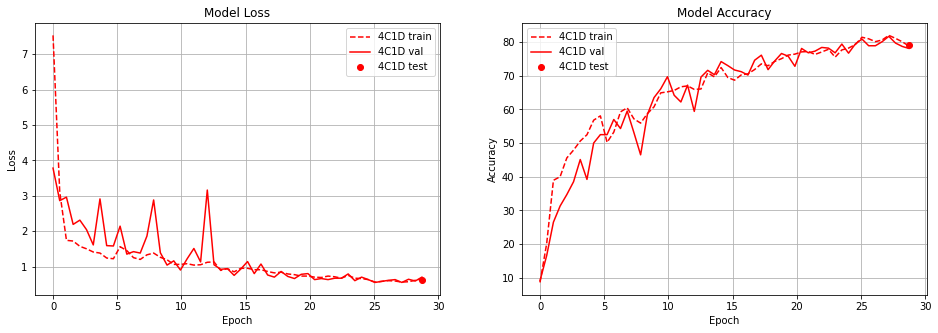

In [14]:
### One of many models I trained for 30 epochs on cifar10 ###
### It will either train and save checkpoints and results.txt,
### Or if there are already results, it will load and plot them
num_epochs = 30
reg = 0.0005
learning_rate=1e-3
num_classes=10
model_name='model4C1DwBNDO'
def model4C1DwBNDO_init_fn():
    return CustomConvNet_4C1DwBNDO(num_classes,reg=reg)
def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate) 

results_path='/content/mydrive/'+model_name+'/'
if os.path.exists(results_path):
  latest = tf.train.latest_checkpoint(results_path)
  print(latest)
  if latest != None:
    print('loading weights...')
    m1 = model4C1DwBNDO_init_fn()
    m1.load_weights(latest)
    m1_test_results = eval(m1)
    m1_results = load_results(results_path)
  else:
    m1,m1_results,max_iter = train(model4C1DwBNDO_init_fn, optimizer_init_fn, num_epochs=num_epochs, reg=reg,model_name=model_name, is_training=True)
    m1_test_results = eval(m1)
  m1_lists=results_dic_to_lists(m1_results,m1_test_results)
  plot_results([m1_lists],['4C1D'])    
else:
  print('Folder does not exist...')

/content/mydrive/model4C2DwBNDO/cp-029.ckpt
loading weights...
Test Loss: 0.54, Test Accuracy: 84.70


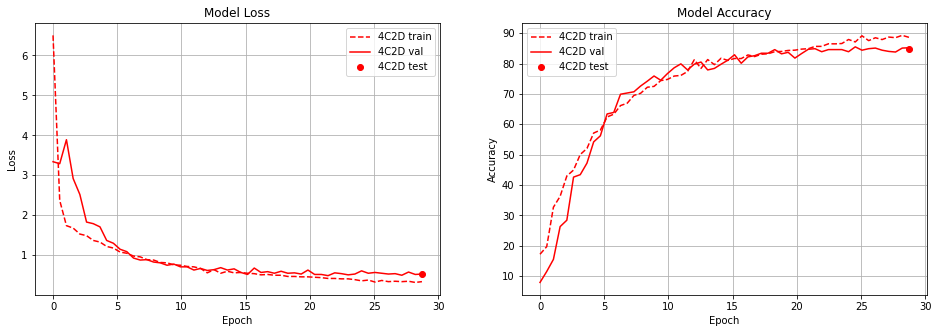

In [15]:
num_epochs = 30
reg = 0.0005
learning_rate=1e-3
num_classes=10
model_name='model4C2DwBNDO'
def model4C2DwBNDO_init_fn():
    return CustomConvNet_4C2DwBNDO(num_classes,reg=reg)
def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate) 

results_path='/content/mydrive/'+model_name+'/'
if os.path.exists(results_path):
  latest = tf.train.latest_checkpoint(results_path)
  print(latest)
  if latest != None:
    print('loading weights...')
    m2 = model4C2DwBNDO_init_fn()
    m2.load_weights(latest)
    m2_test_results = eval(m2)
    m2_results = load_results(results_path)
  else:
    m2,m2_results,max_iter = train(model4C2DwBNDO_init_fn, optimizer_init_fn, num_epochs=num_epochs, reg=reg,model_name=model_name, is_training=True)
    m2_test_results = eval(m2)

m2_lists=results_dic_to_lists(m2_results,m2_test_results)
plot_results([m2_lists],['4C2D'])    

/content/mydrive/model4C3DwBNDO/cp-029.ckpt
loading weights...
Test Loss: 0.52, Test Accuracy: 83.38


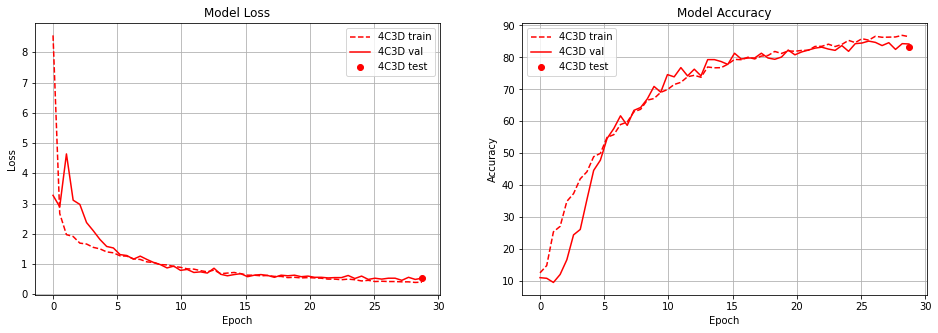

In [16]:
num_epochs = 30
reg = 0.0005
learning_rate=1e-3
num_classes=10
model_name='model4C3DwBNDO'
def model4C3DwBNDO_init_fn():
    return CustomConvNet_4C3DwBNDO(num_classes,reg=reg)
def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate) 

results_path='/content/mydrive/'+model_name+'/'
if os.path.exists(results_path):
  latest = tf.train.latest_checkpoint(results_path)
  print(latest)
  if latest != None:
    print('loading weights...')
    m3 = model4C3DwBNDO_init_fn()
    m3.load_weights(latest)
    m3_test_results = eval(m3)
    m3_results = load_results(results_path)
  else:
    m3,m3_results,max_iter = train(model4C3DwBNDO_init_fn, optimizer_init_fn, num_epochs=num_epochs, reg=reg,model_name=model_name, is_training=True)
    m3_test_results = eval(m3)

m3_lists=results_dic_to_lists(m3_results,m3_test_results)
plot_results([m3_lists],['4C3D'])    


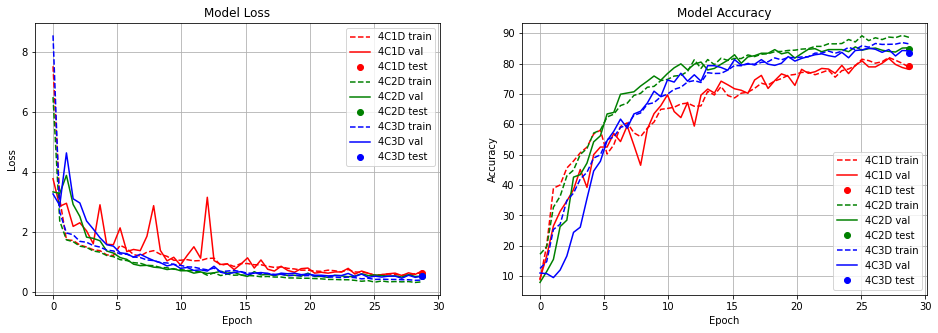

In [17]:
### So lets compare now these three models with 4conv layers and 1-3Dense layers at the end. Not surprisingly 4C1D is the worst, but 4C2D seems to be doing a bit better than 4C3D.
### It can also be noted that the higher capacity model does worse at the start, suggesting it takes a bit longer to learn all its extra parameters. 
### They all appear to have room for improvement with more training, and the higher capacity model may eventually take a lead. 
plot_results([m1_lists, m2_lists,m3_lists],['4C1D','4C2D','4C3D'])    

/content/mydrive/model3C2DwBNDO/cp-029.ckpt
loading weights...
Test Loss: 0.52, Test Accuracy: 84.99


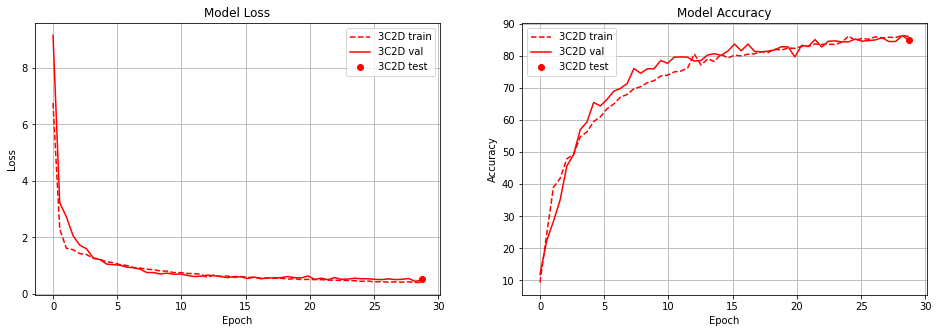

In [18]:
### Now some models: 3C2D, 3C1D
num_epochs = 30
reg = 0.0005
learning_rate=1e-3
num_classes=10
model_name='model3C2DwBNDO'
def model3C2DwBNDO_init_fn():
    return CustomConvNet_3C2DwBNDO(num_classes,reg=reg)
def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate) 

results_path='/content/mydrive/'+model_name+'/'
if os.path.exists(results_path):
  latest = tf.train.latest_checkpoint(results_path)
  print(latest)
  if latest != None:
    print('loading weights...')
    m4 = model3C2DwBNDO_init_fn()
    m4.load_weights(latest)
    m4_test_results = eval(m4)
    m4_results = load_results(results_path)
  else:
    m4,m4_results,max_iter = train(model3C2DwBNDO_init_fn, optimizer_init_fn, num_epochs=num_epochs, reg=reg,model_name=model_name, is_training=True)
    m4_test_results = eval(m4)

m4_lists=results_dic_to_lists(m4_results,m4_test_results)
plot_results([m4_lists],['3C2D'])    

/content/mydrive/model3C1DwBNDO/cp-029.ckpt
loading weights...
Test Loss: 0.55, Test Accuracy: 81.80


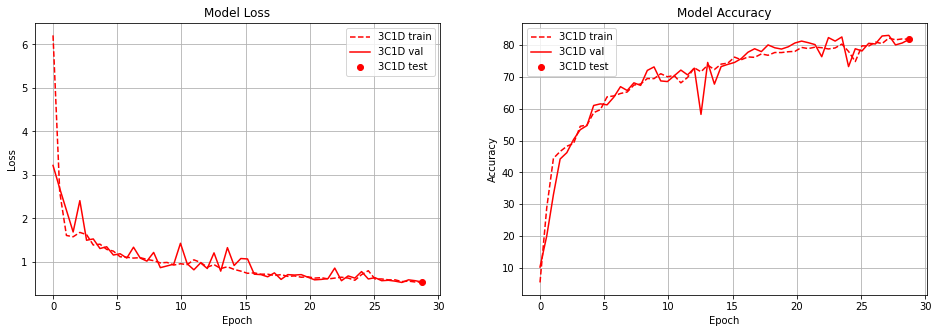

In [19]:
num_epochs = 30
reg = 0.0005
learning_rate=1e-3
num_classes=10
model_name='model3C1DwBNDO'
def model3C1DwBNDO_init_fn():
    return CustomConvNet_3C1DwBNDO(num_classes,reg=reg)
def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate) 

results_path='/content/mydrive/'+model_name+'/'
if os.path.exists(results_path):
  latest = tf.train.latest_checkpoint(results_path)
  print(latest)
  if latest != None:
    print('loading weights...')
    m5 = model3C1DwBNDO_init_fn()
    m5.load_weights(latest)
    m5_test_results = eval(m5)
    m5_results = load_results(results_path)
  else:
    m5,m5_results,max_iter = train(model3C1DwBNDO_init_fn, optimizer_init_fn, num_epochs=num_epochs, reg=reg,model_name=model_name, is_training=True)
    m5_test_results = eval(m5)

m5_lists=results_dic_to_lists(m5_results,m5_test_results)
plot_results([m5_lists],['3C1D'])    

/content/mydrive/model2C2DwBNDO/cp-029.ckpt
loading weights...
Test Loss: 0.56, Test Accuracy: 83.26


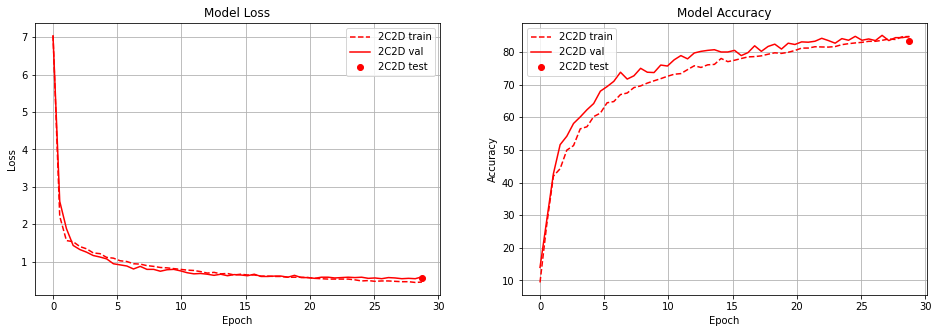

In [20]:
num_epochs = 30
reg = 0.0005
learning_rate=1e-3
num_classes=10
model_name='model2C2DwBNDO'
def model2C2DwBNDO_init_fn():
    return CustomConvNet_2C2DwBNDO(num_classes,reg=reg)
def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate) 

results_path='/content/mydrive/'+model_name+'/'
if os.path.exists(results_path):
  latest = tf.train.latest_checkpoint(results_path)
  print(latest)
  if latest != None:
    print('loading weights...')
    m6 = model2C2DwBNDO_init_fn()
    m6.load_weights(latest)
    m6_test_results = eval(m6)
    m6_results = load_results(results_path)
  else:
    m6,m6_results,max_iter = train(model2C2DwBNDO_init_fn, optimizer_init_fn, num_epochs=num_epochs, reg=reg,model_name=model_name, is_training=True)
    m6_test_results = eval(m6)

m6_lists=results_dic_to_lists(m6_results,m6_test_results)
plot_results([m6_lists],['2C2D'])    

In [21]:
### The run above seems a bit magical in the sense that the val accuracy is larger than the train accuracy for most of the run!! 8P

/content/mydrive/model2C1DwBNDO/cp-029.ckpt
loading weights...
Test Loss: 0.56, Test Accuracy: 80.47


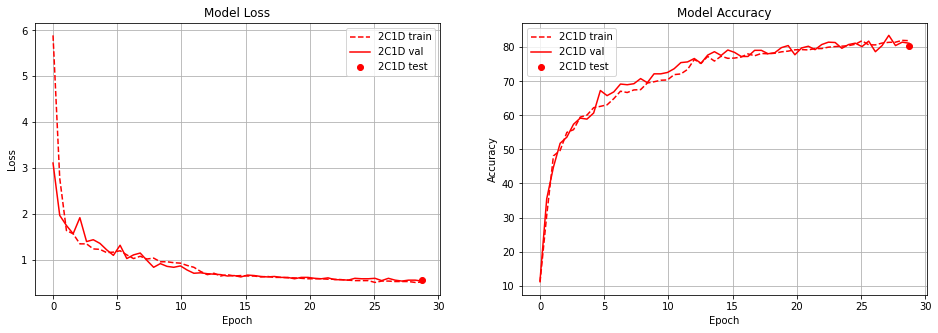

In [22]:
num_epochs = 30
reg = 0.0005
learning_rate=1e-3
num_classes=10
model_name='model2C1DwBNDO'
def model2C1DwBNDO_init_fn():
    return CustomConvNet_2C1DwBNDO(num_classes,reg=reg)
def optimizer_init_fn():
    return tf.keras.optimizers.Adam(learning_rate) 

results_path='/content/mydrive/'+model_name+'/'
if os.path.exists(results_path):
  latest = tf.train.latest_checkpoint(results_path)
  print(latest)
  if latest != None:
    print('loading weights...')
    m7 = model2C1DwBNDO_init_fn()
    m7.load_weights(latest)
    m7_test_results = eval(m7)
    m7_results = load_results(results_path)
  else:
    m7,m7_results,max_iter = train(model2C1DwBNDO_init_fn, optimizer_init_fn, num_epochs=num_epochs, reg=reg,model_name=model_name, is_training=True)
    m7_test_results = eval(m7)

m7_lists=results_dic_to_lists(m7_results,m7_test_results)
plot_results([m7_lists],['2C1D'])    

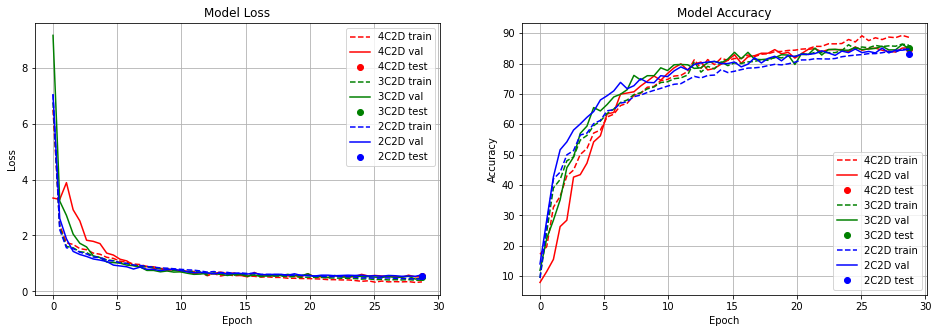

In [23]:
# Lets compare all the models with 2Dense layers at the end:
# Initially, the lower capacity models reach higher accuracies faster, due to having less parameters to optimize.  
# But after 30 epochs, they all reach roughly the same val acc, but the higher capacity models have higher train acc (while early on the order is opposite)
# All models also appear to have an upward trend and could benefit from further training. 
plot_results([m2_lists,m4_lists,m6_lists],['4C2D','3C2D','2C2D'])    

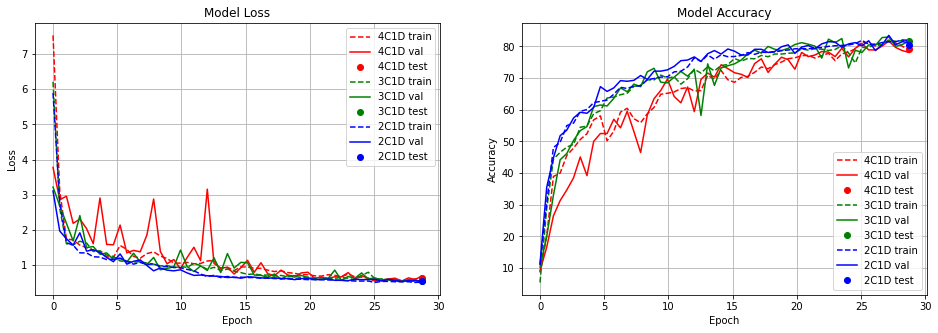

In [24]:
# Similar trends hold for the 1Dlayer models, with the 4C model struggling more at the beginning. 
# The 2D layers give a significant benefit to fitting this data. But 4C layers seem like overkill for this dataset, even though VGG has 5C stacks!
plot_results([m1_lists,m5_lists,m7_lists],['4C1D','3C1D','2C1D'])    

In [25]:
# My goal was to then compare their performace and visualize some examples they get right and wrong, to try and understand how having more layers leads to different feature combinations...
# I wanted to use saliency maps to see what part of the images were being used, and to look at class attribution maps to see what the different trained nets things the classes look like. 
# As well as looking at those of the filters in different layers.  If a 2C net can fit the data, and also 4C, how would their filters differ? Would the 2 extra layers do nothing?
# As you will see I didn't make it quite that far, and find the cifar10 images too small to really find this analysis very useful, but lets have a look. 

In [26]:
class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


In [33]:
# I didn't recalculate these values from each of my nets, which I should have done. But they work ok. 
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)
def deprocess_image(img, rescale=False):
    """Undo preprocessing on an image and convert back to uint8."""
    img = (img * SQUEEZENET_STD + SQUEEZENET_MEAN)
    if rescale:
        vmin, vmax = img.min(), img.max()
        img = (img - vmin) / (vmax - vmin)
    return np.clip(255 * img, 0.0, 255.0).astype(np.uint8)

def preprocess_image(img):
    """Preprocess an image for squeezenet.
    
    Subtracts the pixel mean and divides by the standard deviation.
    """
    return (img.astype(np.float32)/255.0 - SQUEEZENET_MEAN) / SQUEEZENET_STD


In [34]:
# A function I wrote to eval the model and get the stats of which it gets right and wrong output as well. 
def get_false_pred(model,X,y):
  # test_success=(model(X_test, training=False)==y_test)
  pred=model(X_test, training=False)
  corr=[]
  for k in range(len(y)):
    if np.argmax(pred[k])==y[k]:
      corr.append(1)
    else:
      corr.append(0)
  # print(sum(corr), corr)
  print(sum(corr)/len(y)*100)
  id_false=np.where(np.array(corr)==0)[0]
  # print(id_false)
  id_true=np.where(np.array(corr)==1)[0]
  return pred,corr,id_false,id_true  

In [35]:
# For now I will compare only 2 models, m6=2C2D & m7=2C1D
m6_pred,m6_corr,m6_id_false,m6_id_true=get_false_pred(m6,X_test,y_test)
m7_pred,m7_corr,m7_id_false,m7_id_true=get_false_pred(m7,X_test,y_test)

83.26
80.47


In [36]:
m6_id_false,m7_id_false

(array([  22,   24,   35, ..., 9985, 9989, 9993]),
 array([   3,   24,   32, ..., 9989, 9995, 9996]))

In [37]:
# lets get a list of the really hard images that both nets got wrong. 
# note they also make several different mistakes. 
both_false=list(set(m6_id_false).intersection(m7_id_false))

print(len(m6_id_false),len(m7_id_false),len(both_false))

1674 1953 1201


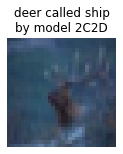

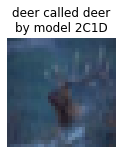

In [38]:
### Lets plot an example image and see how each model classified this image. 
### In this case the smarter net got it wrong, while the simpler net got it right... personally I find these images hard to classify myself sometimes. 

# idx=m6_id_false[12] #5->airplane
# print(idx)
idx=22 #24 #change the image idx here to look at how they did on another image. 
# idx=both_false[1]
img=deprocess_image(X_test[idx])
plt.figure(30,figsize=(2,2))
plt.imshow(img)
plt.title(class_names[y_test[idx]]+' called '+class_names[np.argmax(m6_pred[idx])]+'\nby model 2C2D' )
plt.axis('off')
plt.show()

img=deprocess_image(X_test[idx])
plt.figure(30,figsize=(2,2))
plt.imshow(img)
plt.title(class_names[y_test[idx]]+' called '+class_names[np.argmax(m7_pred[idx])]+'\nby model 2C1D' )
plt.axis('off')
plt.show()

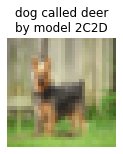

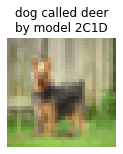

In [39]:
idx=24 #Here's one they both get wrong... granted it does look a bit like a deer. 
# idx=both_false[1]
img=deprocess_image(X_test[idx])
plt.figure(30,figsize=(2,2))
plt.imshow(img)
plt.title(class_names[y_test[idx]]+' called '+class_names[np.argmax(m6_pred[idx])]+'\nby model 2C2D' )
plt.axis('off')
plt.show()

img=deprocess_image(X_test[idx])
plt.figure(30,figsize=(2,2))
plt.imshow(img)
plt.title(class_names[y_test[idx]]+' called '+class_names[np.argmax(m7_pred[idx])]+'\nby model 2C1D' )
plt.axis('off')
plt.show()

In [40]:
# This is a stange object full of integers that will be useful for generating saliency maps. 
yConstant=np.zeros((10000,10),dtype=np.int32)
for k in range(10):
  yConstant[:,k]=k

In [41]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for X, numpy of shape (N,)
    - model: A SqueezeNet model that will be used to compute the saliency map.

    Returns:
    - saliency: A numpy array of shape (N, H, W) giving the saliency maps for the
    input images.
    """
    N,H,W,_ = X.shape
    X = tf.convert_to_tensor(X)
    with tf.GradientTape() as t:
        t.watch(X)
        scores = model.call(X)
        Yscores = tf.gather_nd(scores, tf.stack((tf.range(N), y), axis=1))
        loss = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = Yscores)
    grads = t.gradient(loss,X)    
    saliency = tf.keras.backend.max(grads,axis = 3)
    return saliency

def show_saliency_maps(X, y, mask,model):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]

    prt_str='Shape of X is {} and y is {}'
    print(prt_str.format(Xm.shape,ym.shape))
    saliency = compute_saliency_maps(Xm, ym, model)
    abs_saliency = abs(np.copy(saliency))
    prediction_m = model(Xm, training=False)
    for i in range(mask.size):
        plt.subplot(2, mask.size, i + 1)
        plt.imshow(deprocess_image(Xm[i]))
        plt.axis('off')
        plt.title(class_names[ym[i]]+' called '+class_names[np.argmax(prediction_m[i])])
        plt.subplot(2, mask.size, mask.size + i + 1)
        print(ym[i], np.argmax(prediction_m[i]))
        # plt.title(class_names[ym[i]])
        plt.imshow(abs_saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(10, 4)
    plt.show()

def show_saliency_maps2(X, y, mask,model):
    mask = np.asarray(mask)
    Xm = X[mask]
    ym = y[mask]

    prt_str='Shape of X is {} and y is {}'
    print(prt_str.format(Xm.shape,ym.shape))
    saliency = compute_saliency_maps(Xm, ym, model)
    abs_saliency = abs(np.copy(saliency))
    prediction_m = model(Xm, training=False)
    for i in range(mask.size):
        plt.subplot(3, mask.size, i + 1)
        plt.imshow(deprocess_image(Xm[i]))
        plt.axis('off')
        plt.title(class_names[ym[i]]+' called '+class_names[np.argmax(prediction_m[i])])
        plt.subplot(3, mask.size, mask.size + i + 1)
        print(ym[i], np.argmax(prediction_m[i]))
        plt.imshow(abs_saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.subplot(3, mask.size, 2*mask.size + i + 1)
        plt.plot(prediction_m[i], '.',color='k',markersize=10)
        plt.title('Class Predictions')
        plt.plot(np.argmax(prediction_m[i]),prediction_m[i][np.argmax(prediction_m[i])], '.',color='g',markersize=7)
        plt.gcf().set_size_inches(9, 6)
    plt.show()


def show_all_saliency_maps(X0, y0, mask,model,alpha=0.5):
    mask = np.asarray(mask)
    X = X0[mask]
    y = y0[mask]
    # prt_str='Shape of X is {} and y is {}'
    # print(prt_str.format(X.shape,y.shape))
    pred = model(X, training=False)
    # prt_str='Shape of Pred is {}'
    # print(prt_str.format(pred.shape))
    saliency=np.zeros((X.shape[0],32,32,10))
    # print(saliency.shape)
    for k in range(10):
      # prt_str='For class {} the yMask is {}'
      # print(prt_str.format(k,yConstant[mask,k]))
      sal=compute_saliency_maps(X, yConstant[mask,k], model)
      # prt_str='Shape of the sal for this class is {}'
      # print(prt_str.format(sal.shape))
      saliency[:,:,:,k]=sal
    for i in range(mask.size):
        plt.figure(i,figsize=(20,4))
        plt.subplot(2,10,y[i]+1)
        plt.imshow(deprocess_image(X[i]))
        plt.axis('off')
        plt.title(class_names[y[i]]+' called '+class_names[np.argmax(pred[i])])
        for j in range(10):
          plt.subplot(2,10,10+1+j)
          title_str=class_names[j]+'->{:.2f}'
          plt.title(title_str.format(np.array(pred)[i][j]))
          plt.imshow(deprocess_image(X[i]),alpha=1)
          plt.imshow(abs(saliency[i,:,:,j]), cmap=plt.cm.hot,alpha=alpha)
          plt.axis('off')
    plt.show()



In [42]:
# class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

Shape of X is (3, 32, 32, 3) and y is (3,)
2 2
4 8
5 4


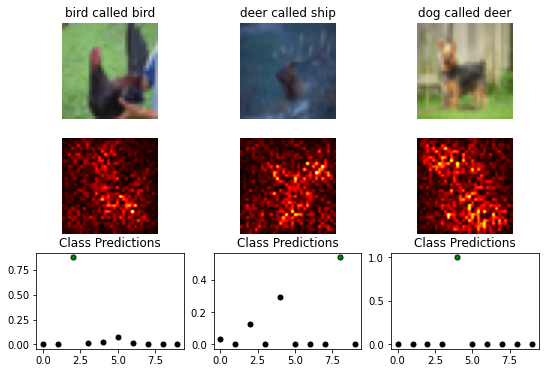

In [43]:
# So lets look at some predictions its gets right and wrong
# The first is a bird predicted as a bird, correctly, but it thought it might maybe be a dog. This is not apparent from the saliency map
# The second is a deer which gets called a ship. From the prediction scores, its next guess was deer, and then bird. The saliency map looks more like a deer to me. 
# Finally the last image is a dog which it CONFIDENTLY classified as a deer. While the saliency map doesn't look like much. 
show_saliency_maps2(X_test, y_test, [25, 22,24],m6)

Shape of X is (3, 32, 32, 3) and y is (3,)
2 2
4 4
5 4


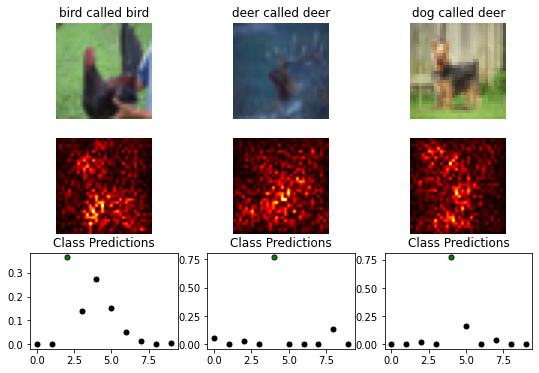

In [44]:
# What about m7=2C1D? 
# It still gets the bird right, but isn't confident and thinks it could be a cat, deer, dog or frog!!! yikes
# This one does better on the deer, but still thinks it could be a ship. 
# Finally this one also thinks the dog is a deer, but is a little less confident, and suspects at least it could be a dog. But both saliency maps that led to the deer prediction are quite different :/ 
show_saliency_maps2(X_test, y_test, [25, 22,24],m7)

In [71]:
### There is also a caveat to the saliency maps above: the salinecy map is calculated relative to the choice the model made, but there are also 9 other choices it didn't make,
### and the saliency map can also show the pixels sensative to that decision too. So next we'll take a look at all of them. 

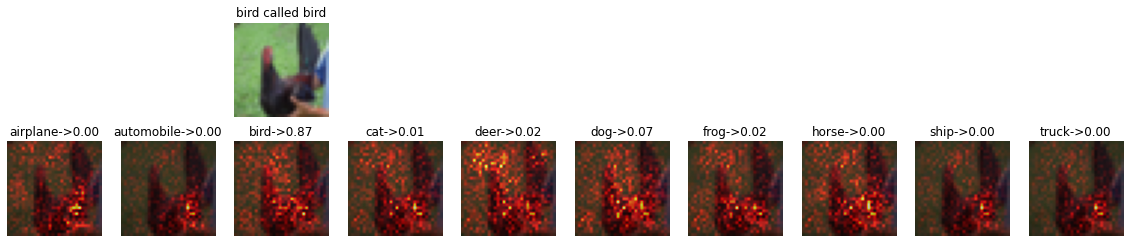

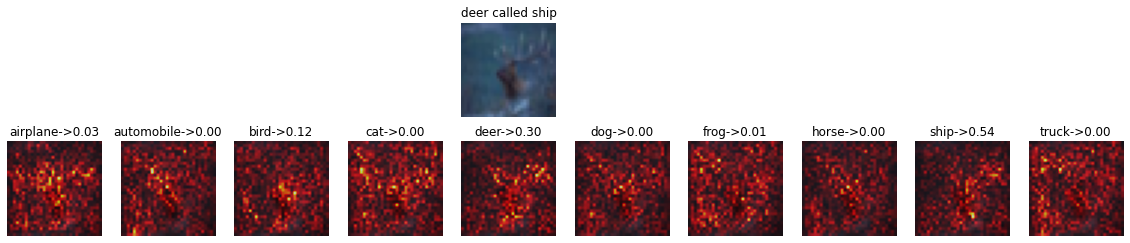

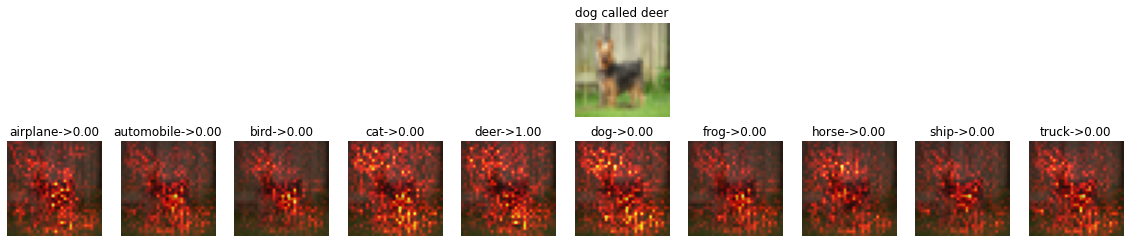

In [76]:
show_all_saliency_maps(X_test, y_test, [25,22,24],m6,alpha=0.7)

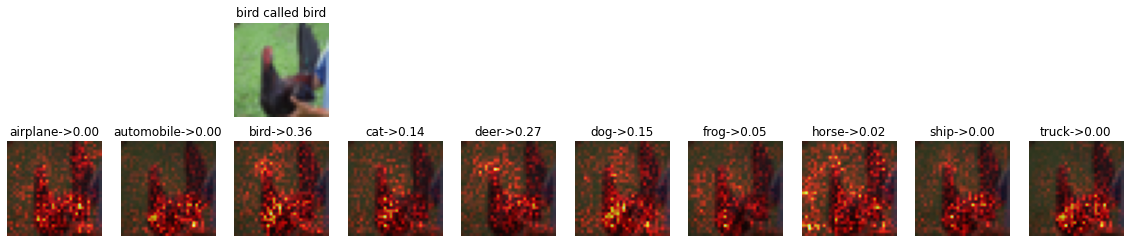

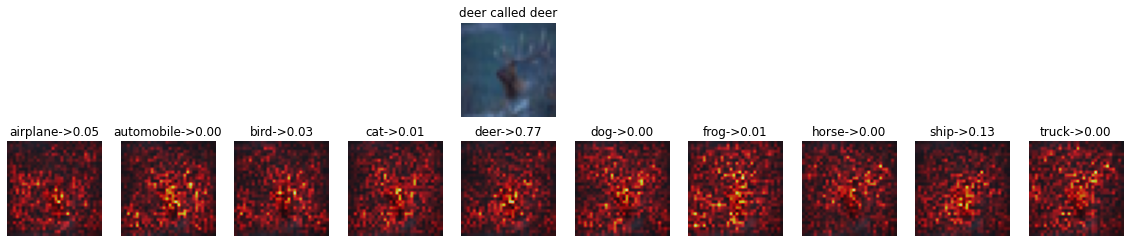

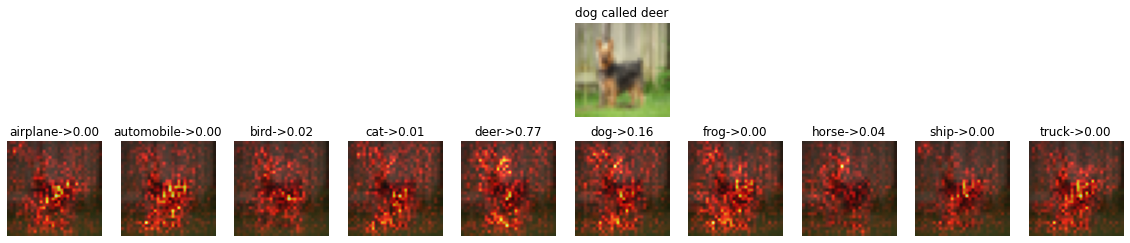

In [79]:
## So do they look much different for another model?
show_all_saliency_maps(X_test, y_test, [25,22,24],m7,alpha=0.7)

In [80]:
### After staring at many of the saliency maps that lead to correct or false predictions in cifar10, they don't appear to be very informtive as to 
### why they were correct or not.  One problem is that the images are all very small, and the objects are not clear to my human visual system.  Also the objects are generally 
### centered in the image so don't leave room to be interpreted as spatial attention or object localization masks. In part2 we will take a look at some pretrained models with imagenet. 

In [45]:
## Function for generating class activation maximization images. 
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    return X
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: Tensor of shape (N, H, W, C)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new Tensor of shape (N, H, W, C)
    """
    if ox != 0:
        left = X[:, :, :-ox]
        right = X[:, :, -ox:]
        X = tf.concat([right, left], axis=2)
    if oy != 0:
        top = X[:, :-oy]
        bottom = X[:, -oy:]
        X = tf.concat([bottom, top], axis=1)
    return X

def create_class_visualization(target_y, model, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to jitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)
    verbose = kwargs.pop('verbose', True)
    
    # We use a single image of random noise as a starting point
    X = 255 * np.random.rand(32, 32, 3)
    X = preprocess_image(X)[None]

    loss = None # scalar loss
    grad = None # gradient of loss with respect to model.image, same size as model.image
    
    X = tf.Variable(X)
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(0, max_jitter, 2)
        X = jitter(X, ox, oy)
        
        with tf.GradientTape() as tape:
            tape.watch(X)
            scores = model.call(X)
            target_score = scores[0,target_y]
        grads = tape.gradient(target_score,X)
        dX = learning_rate*grads
        dX -=l2_reg*((X-tf.reduce_mean(X))**2)
        X +=dX

        # Undo the jitter
        X = jitter(X, -ox, -oy)
        # As a regularizer, clip and periodically blur
        
        X = tf.clip_by_value(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=0.5)
        if verbose:
          # Periodically show the image
          if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
              # print(.shape)
              plt.imshow(deprocess_image(X[0]))
              class_name = class_names[target_y]
              plt.title('%s\nIteration %d / %d\nPred=%.3f' % (class_name, t + 1, num_iterations,target_score))
              plt.gcf().set_size_inches(2, 2)
              plt.axis('off')
              plt.show()
    return X

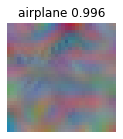

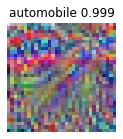

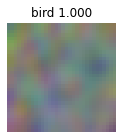

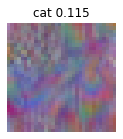

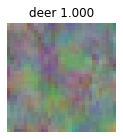

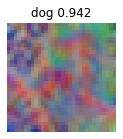

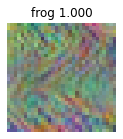

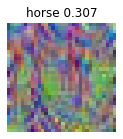

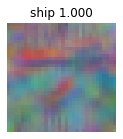

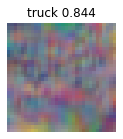

In [46]:
##Lets generate some images, one for each class, showing what the model thinks that class looks like. Or at least a non unique image that it classifies as that class.
##Spoiler alert: the images look nothing like the classes, no matter how hard you squint your mind... yet the model predicts a class with perfect confidence in many cases. 
## I would like to also look at what different filters respond for, but results here aren't good, so lets wait for part two and look at imagenet. 
class_images=[]
for k in range(10):
  try:
    x0=create_class_visualization(k, m6, num_iterations=200,verbose=False)
    class_images.append(x0)
    plt.figure(figsize=(2,2))
    plt.imshow(deprocess_image(x0[0,:,:,:]))
    pred0=m6(x0)
    str_title=class_names[k]+' {:.3f}'
    plt.title(str_title.format(pred0[0][k]))
    plt.axis('off')
    plt.show()
  except:
    print(str(k)+'th image generation failed.')

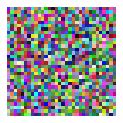

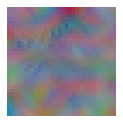

In [54]:
### Lets compare a noise image to one that's supposed to be an airplane
x00 = 255 * np.random.rand(32, 32, 3)
x00 = preprocess_image(x00)[None]
plt.figure(figsize=(2,2))
plt.imshow(deprocess_image(x00[0,:,:,:]))
plt.axis('off')
plt.show()

x0=class_images[0]
plt.figure(figsize=(2,2))
plt.imshow(deprocess_image(x0[0,:,:,:]))
plt.axis('off')
plt.show()

In [48]:
### Here we can see that the network confidently predicts the noise is a frog, and that the airplane is in fact an airplane. 
pred00=m6(x00)
print(pred00[0],class_names[np.argmax(pred00)])

pred0=m6(x0)
print(pred0[0],class_names[np.argmax(pred0)])


tf.Tensor(
[7.1355171e-05 3.2911138e-04 1.7504948e-03 4.8870114e-03 1.2385675e-05
 8.6117063e-05 9.9277377e-01 7.2589419e-06 5.4323682e-06 7.7088902e-05], shape=(10,), dtype=float32) frog
tf.Tensor(
[9.9648958e-01 1.6972314e-03 3.8354579e-04 1.9247114e-04 6.8306122e-07
 5.1597376e-06 1.7167899e-06 5.2850748e-08 1.1906013e-03 3.8839196e-05], shape=(10,), dtype=float32) airplane


In [51]:
m6_class_img=np.zeros((10,32,32,3))
for k in range(num_classes):
  print(k)
  x0=create_class_visualization(k, m6, num_iterations=500,verbose=False)
  # x0=create_class_visualization(k, m6, num_iterations=500,verbose=False)
  print(x0.shape)
  m6_class_img[k,:,:,:]=x0



0
(1, 32, 32, 3)
1
(1, 32, 32, 3)
2
(1, 32, 32, 3)
3
(1, 32, 32, 3)
4
(1, 32, 32, 3)
5
(1, 32, 32, 3)
6
(1, 32, 32, 3)
7
(1, 32, 32, 3)
8
(1, 32, 32, 3)
9
(1, 32, 32, 3)


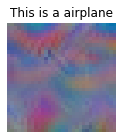

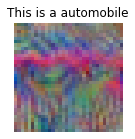

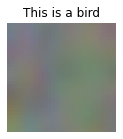

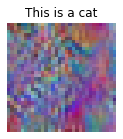

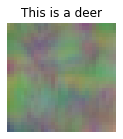

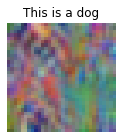

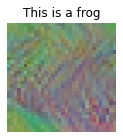

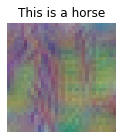

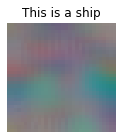

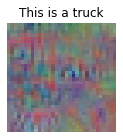

In [53]:
for k in range(num_classes):
  class_id=k
  plt.figure(301,figsize=(2,2))
  plt.imshow(deprocess_image(m6_class_img[class_id,:,:,:]))
  plt.title('This is a '+class_names[class_id])
  plt.axis('off')
  plt.show()

In [ ]:

# img100=m6_class_img[class_id,:,:,:]=create_class_visualization(class_id, m6,num_iterations=100)
# img200=m6_class_img[class_id,:,:,:]=create_class_visualization(class_id, m6,num_iterations=200)
# img300=m6_class_img[class_id,:,:,:]=create_class_visualization(class_id, m6,num_iterations=300)


In [141]:
m6_img100_pred=m6(img100)
print(np.argmax(m6_img100_pred))
m6_img200_pred=m6(img200)
print(np.argmax(m6_img200_pred))
m6_img300_pred=m6(img300)
print(np.argmax(m6_img300_pred))

1
0
0


In [143]:
m6_img300_pred

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[8.2351542e-01, 1.7527394e-01, 7.0973038e-04, 3.7144164e-05,
        4.5041829e-06, 4.8950642e-07, 8.6708067e-05, 1.9295519e-05,
        2.9367738e-04, 5.9083995e-05]], dtype=float32)>